In [19]:
# imports and configs

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import world_bank_data as wb

# make plots a bit bigger
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 20]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
print(pd.options.display.max_rows)
print(pd.options.display.expand_frame_repr)
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

20
False


In [7]:
# --------------------------------------------------
# load the datasets


df_c = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_d = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_r = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

# --------------------------------------------------
# next rotate them to add a Date column

ids = ['Country/Region', 'Province/State', 'Lat', 'Long']
numericalbase = ['Confirmed', 'Deaths', 'Recovered']

df_c = df_c.melt(id_vars=ids, var_name="Date", value_name="Confirmed")
df_d = df_d.melt(id_vars=ids, var_name="Date", value_name="Deaths")
df_r = df_r.melt(id_vars=ids, var_name="Date", value_name="Recovered")

# --------------------------------------------------
# next merge the Confirmed/Deaths/Recovered into one dataframe

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
keys = ids + ["Date"]

df = pd.merge(df_c, df_d, how='outer', on=keys)
df = pd.merge(df, df_r, how='outer', on=keys)
df = df.reset_index()

# --------------------------------------------------

for n in numericalbase:
    df[n] = df[n].fillna(0)

# --------------------------------------------------
# ad an active column

df['Active'] = df['Confirmed'] - (df['Recovered'] + df['Deaths'])

numericalbase.append('Active')

# --------------------------------------------------
# some countries have no Province/State, we need empty strings

df['Province/State'] = df['Province/State'].fillna('-')

# --------------------------------------------------
# finally cleanup the dates (who uses M/D/Y in a dataset ???)

#print(df)
#for d in df['Date']:
#    print(d)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# --------------------------------------------------
# add an Id column

df['Id'] = df['Country/Region'] + '-' + df['Province/State']

# --------------------------------------------------
# add Increase columns

numericalcolors = { 'Confirmed':'blue',
                    'Deaths':   'red',
                    'Recovered':'green',
                    'Active':   'orange' }

numerical = []
gb = df.groupby('Id')
for n in numericalbase:
    numerical.append(n)
    
    ni = '%sIncrease' % n
    df[ni] = gb[n].diff()
    numerical.append(ni)
    
    #na = '%sAvg' % n
    #df[na] = gb[n].apply(pd.rolling_mean, 3, min_periods=1)
    #df[na] = gb[n].transform('cumsum')
    #numericalx.append(na)
    
# --------------------------------------------------
# these are the columns we may want to sum later

aggregation = {}
for n in numerical:
    aggregation[n] = 'sum'

# --------------------------------------------------
# fix column order

cols = ['Id'] + keys + numerical

df = df[cols]

# --------------------------------------------------
# sort by Confirmed column

#df = df.sort_values(by=['Date', 'Confirmed'])

# --------------------------------------------------
# write it for review

df.to_csv("csse-combined.csv", index=False)

# --------------------------------------------------
# dump

#for c in df.columns:
#    u = df[c].unique()
#    print("%-20s %u" % (c, len(u)))

#print(df['Country/Region'].unique())

df.describe(include="all")

,Id,Country/Region,Province/State,Lat,Long,Date,Confirmed,ConfirmedIncrease,Deaths,DeathsIncrease,Recovered,RecoveredIncrease,Active,ActiveIncrease
count,16380,16380,16380,16380.000000,16380.000000,16380,16380.000000,16131.000000,16380.000000,16131.000000,16380.000000,16131.000000,16380.000000,16131.000000
unique,249,175,77,NaN,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Timor-Leste--,China,-,NaN,NaN,2020-02-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,130,2145,11440,NaN,NaN,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2020-01-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,22.171871,24.140059,NaN,426.764896,32.795425,16.027656,1.484905,141.985043,7.570640,268.752198,23.739880
std,NaN,NaN,NaN,24.681339,71.439296,NaN,4097.467154,367.960123,212.300912,22.006750,2121.264802,98.500313,2588.939798,333.284296
min,NaN,NaN,NaN,-41.454500,-135.000000,NaN,0.000000,-15.000000,0.000000,-5.000000,0.000000,-41.000000,-184.000000,-2743.000000
25%,NaN,NaN,NaN,7.844875,-15.212825,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


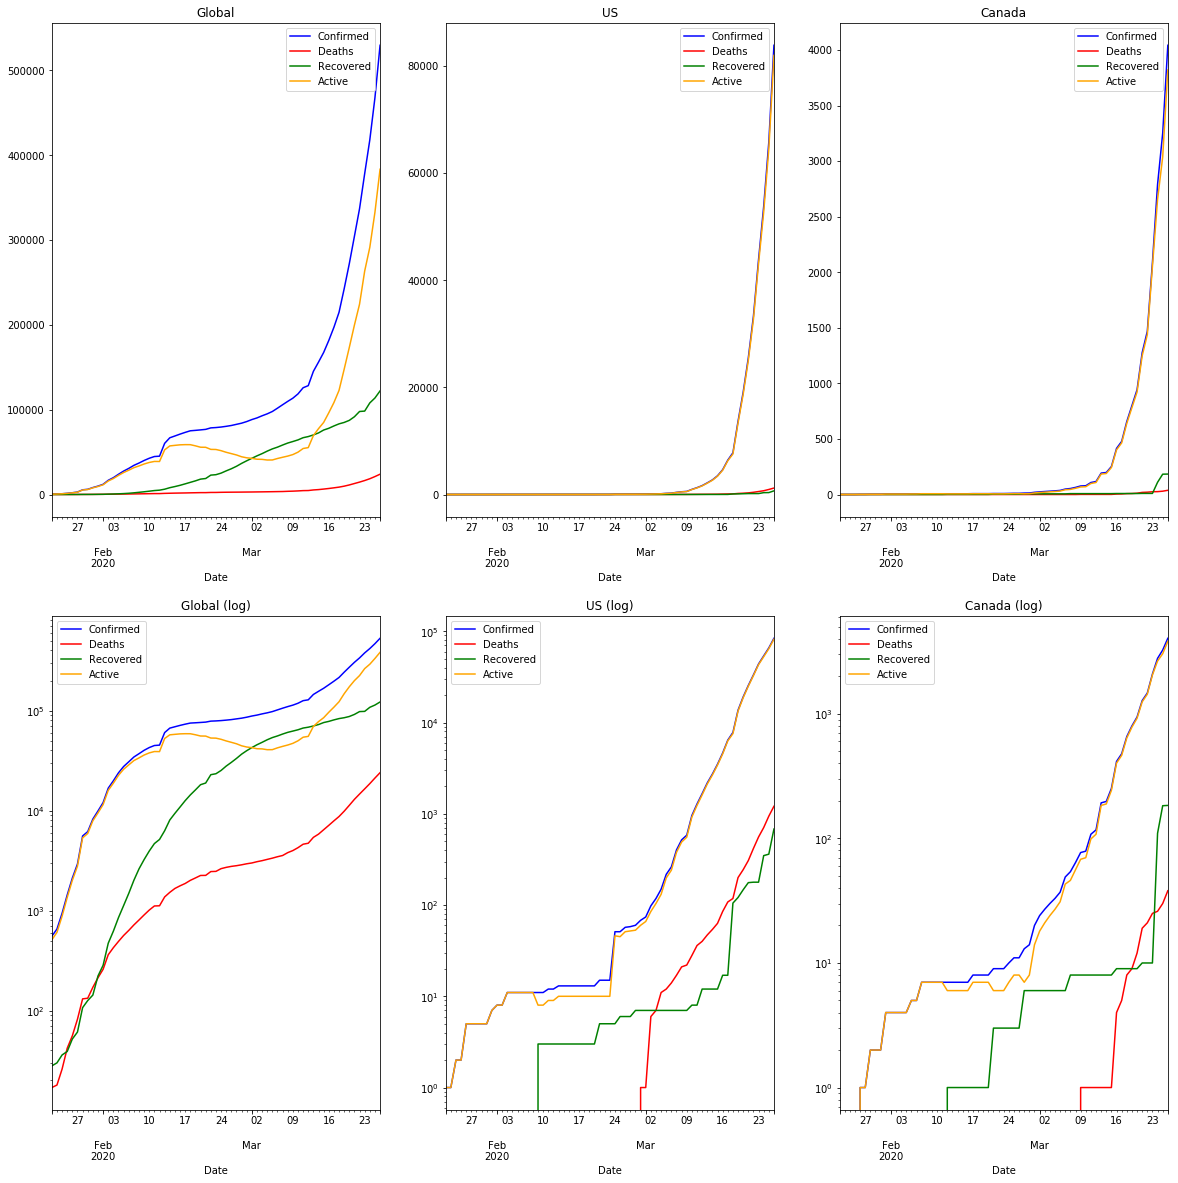

In [8]:
gbl = df.groupby(['Date'],as_index=False).agg(aggregation)

cdn = df.loc[df['Country/Region'] == 'Canada']
cdn = cdn.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

usa = df.loc[df['Country/Region'] == 'US']
usa = usa.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

DATA = [{'n':'Global', 'df':gbl},
        {'n':'US',     'df':usa},
        {'n':'Canada', 'df':cdn}]

fig, axs = plt.subplots(2, len(DATA))

i=0
for d in DATA:
    p = d['df']
    
    #print(d['n'])
    #print(p)
    
    ax = axs[0][i]
    ax.set_title(d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % d['n'])
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    i = i+1

plt.show()


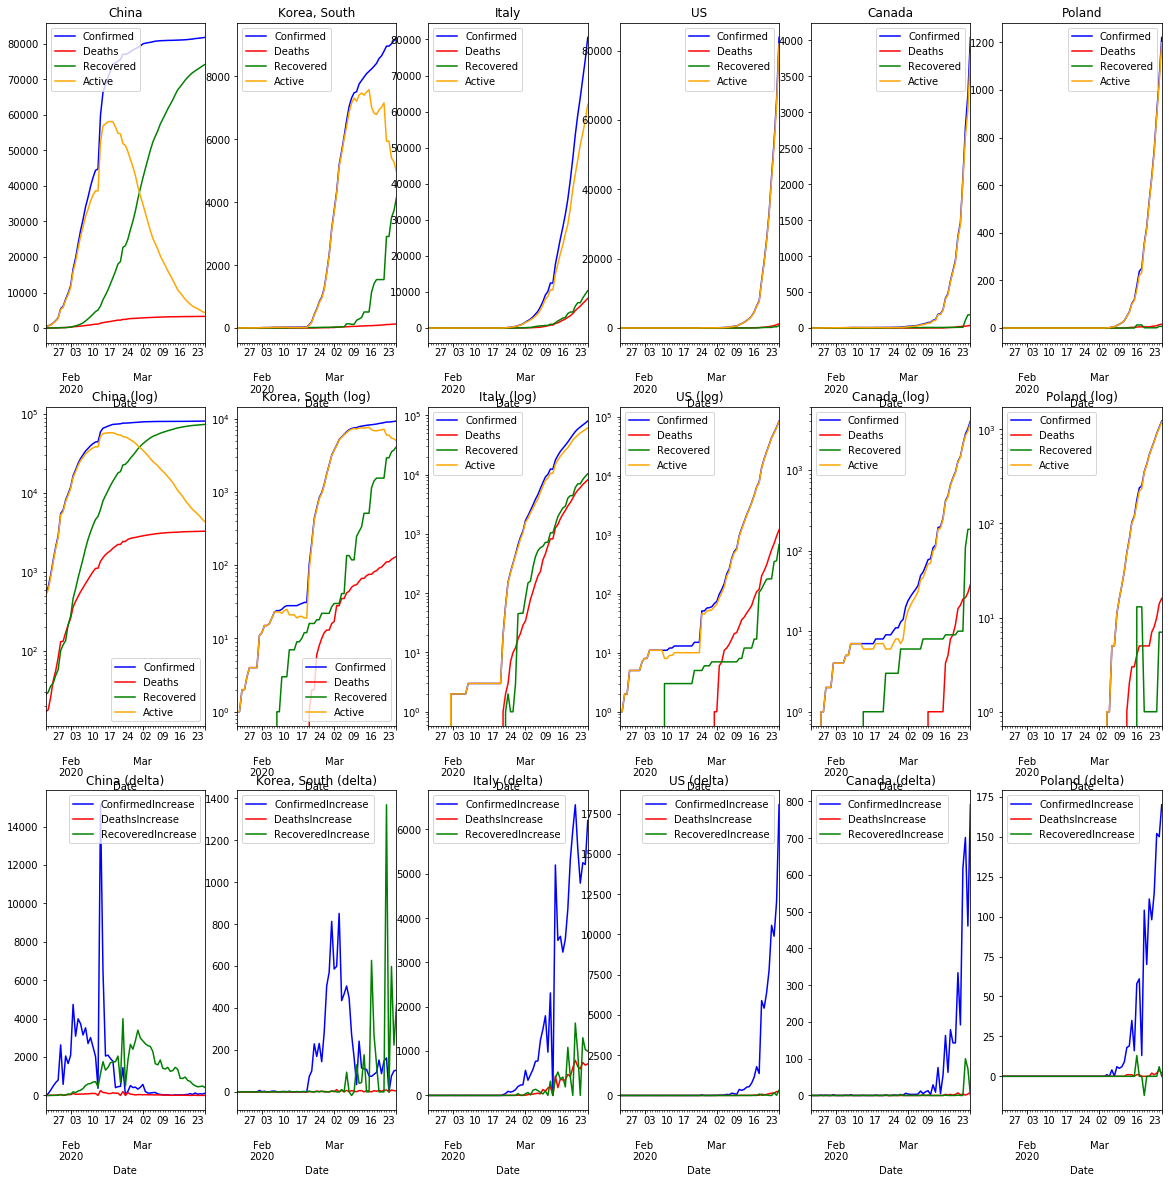

In [9]:
#print(df['Country/Region'].unique())
countries = ['China', 'Korea, South', 'Italy', 'US', 'Canada', 'Poland']

fig, axs = plt.subplots(3, len(countries))

i = 0
for country in countries:
    p = df.loc[df['Country/Region'] == country]
    p = p.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

    ax = axs[0][i]
    ax.set_title(country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)


    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % country)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[2][i]
    ax.set_title("%s (delta)" % country)
    for col in numericalbase:
        if col == "Active":
            continue
        p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

    i = i + 1

fig.savefig('out/countries.png')
plt.show()


['Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick']


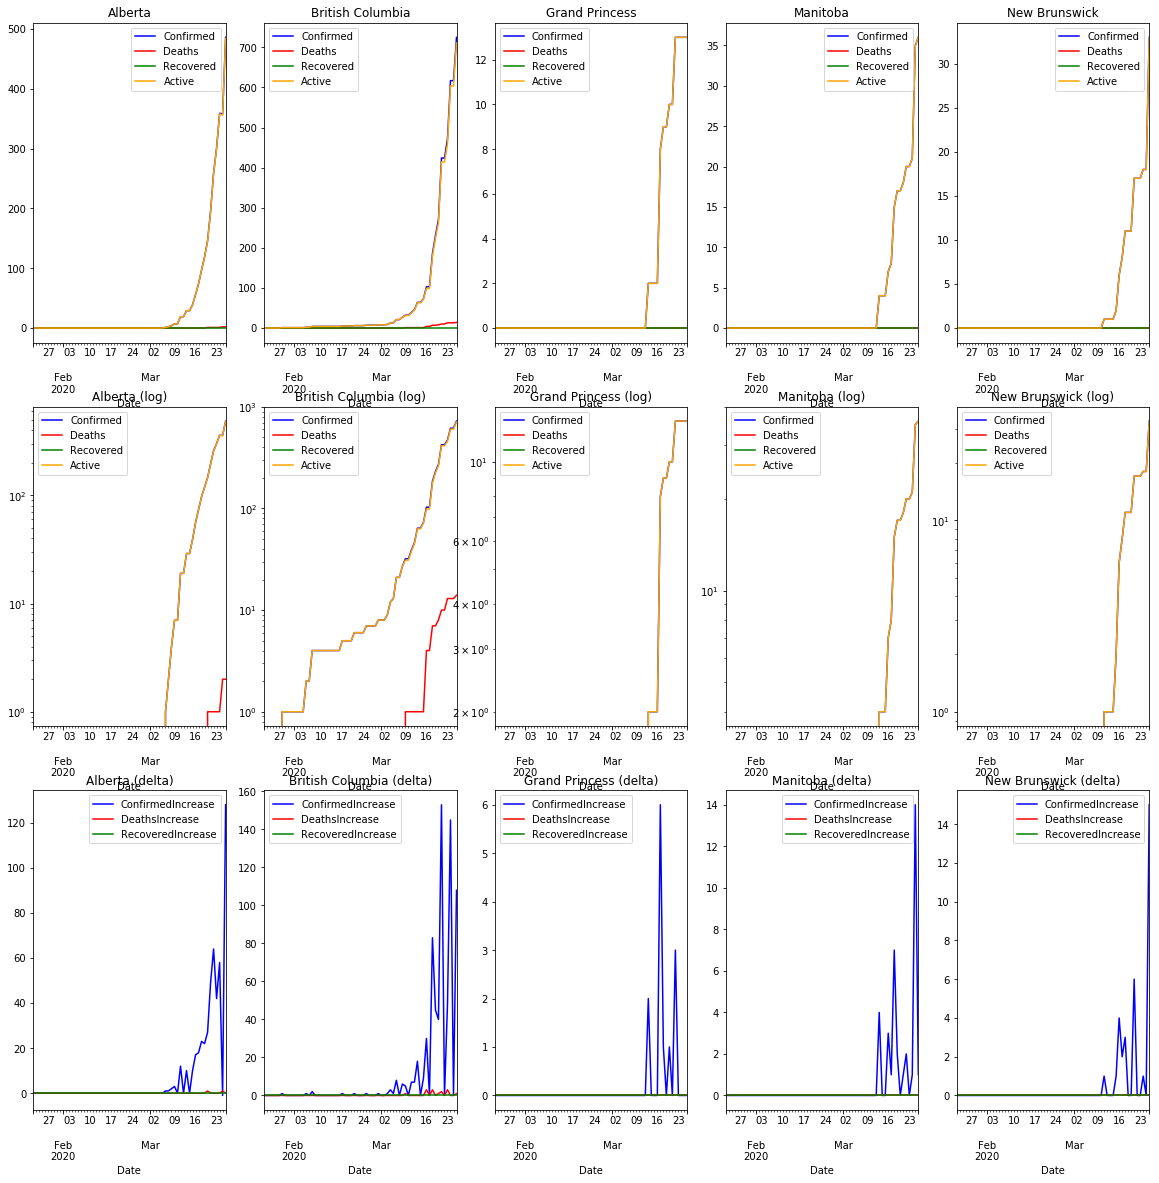

In [10]:
country = 'Canada'
cdf = df.loc[df['Country/Region'] == country]
regions = cdf['Province/State'].unique()
regions = regions[0:5]

print(regions)

fig, axs = plt.subplots(3, len(regions))

i = 0
for region in regions:
    d = cdf.loc[df['Province/State'] == region]

    p = d.groupby(['Province/State','Date'],as_index=False).agg(aggregation)

    #print(p)
    
    ax = axs[0][i]
    ax.set_title(region)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[1][i]
    ax.set_yscale('log')
    ax.set_title("%s (log)" % region)
    for col in numericalbase:
        p.plot(kind='line',x='Date',y=col, color=numericalcolors[col], ax=ax)

    ax = axs[2][i]
    ax.set_title("%s (delta)" % region)
    for col in numericalbase:
        if col == "Active":
            continue
        p.plot(kind='line',x='Date',y="%sIncrease"%col, color=numericalcolors[col], ax=ax)

    i = i + 1


fig.savefig('out/canada.png')
plt.show()


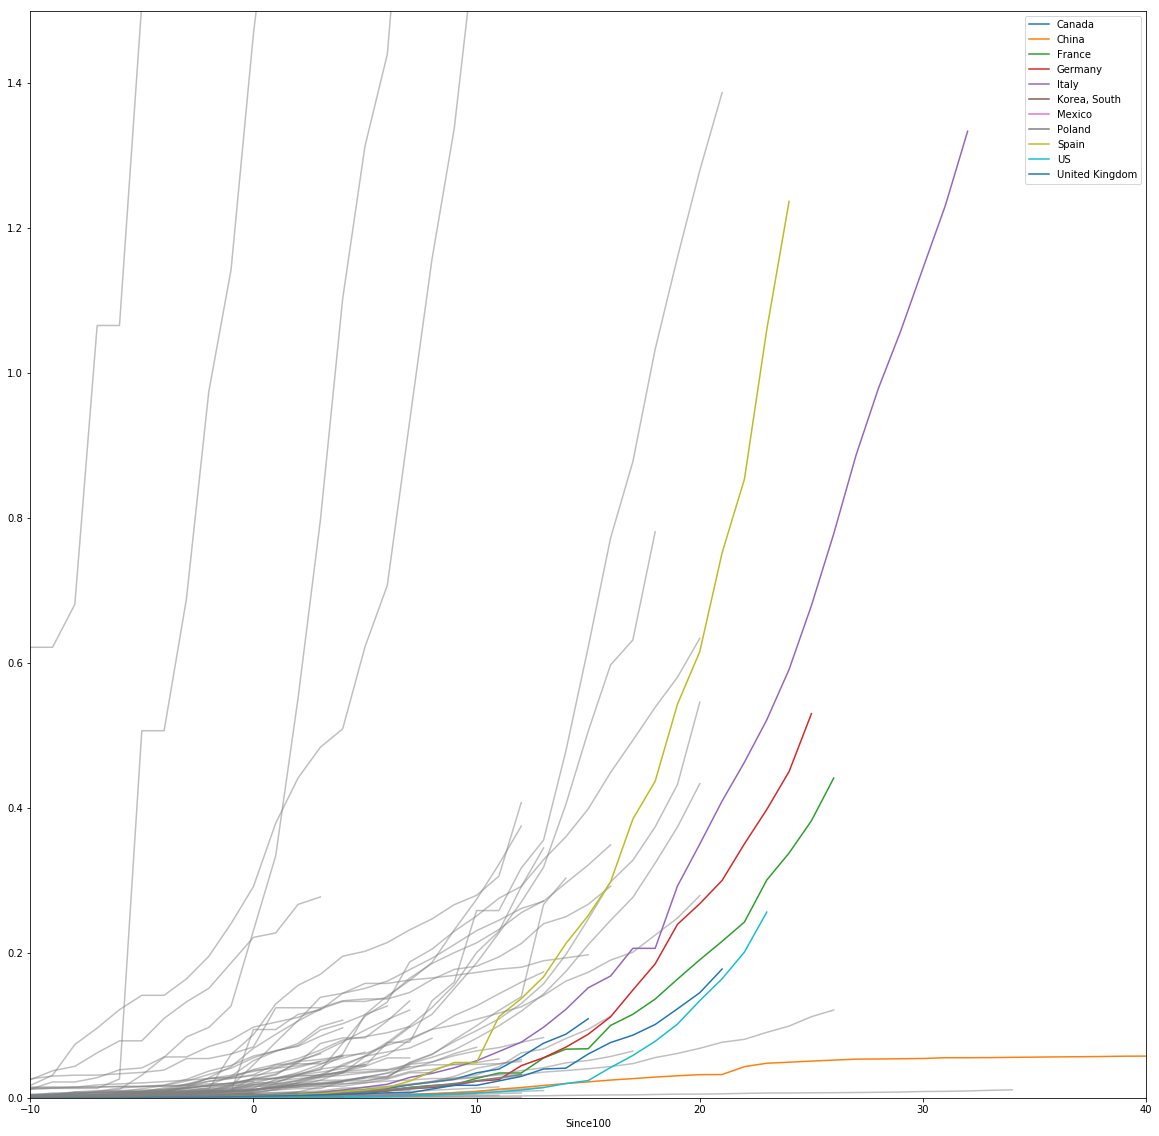

In [45]:
pop = wb.get_series('SP.POP.TOTL', mrv=1).reset_index()


pc = ['Country/Region', 'Province/State', 'Date', 'Confirmed', 'ConfirmedIncrease', 'Deaths', 'DeathsIncrease', 'Recovered', 'RecoveredIncrease', 'Active', 'ActiveIncrease']
d = df[pc]
d = d.groupby(['Country/Region','Date'],as_index=False).agg(aggregation)

countries = d['Country/Region'].unique()

focus = ['Canada','US','China','Korea, South','United Kingdom','Poland','Mexico','Italy','Spain','France','Germany']

#countries = focus
#d = d[d['Country/Region'].isin(focus)]

#d = d.reset_index()

#print(d)
#display(countries)
#display(d)

fig, ax = plt.subplots(1,1)


for cn in countries:
    pn = cn
    if pn == 'US':
        pn = 'United States'
    
    num = 0
    try:
        num = int(pop[pop['Country'] == pn]['SP.POP.TOTL'])
    except:
        pass
    
    try:
        c = d[d['Country/Region'] == cn]
        x = c[c['Confirmed'].gt(99)].index[0]
        s = c.loc[x]['Date']
        c = c.copy()
        c['Since100'] = c['Date'] - s
        c['Since100'] = c['Since100']/np.timedelta64(1,'D')
        c = c[c['Since100'] > -14]
        
        c['ConfPer1000'] = c['Confirmed'] * 1000 / num
        

        if cn in focus:
            c.plot(kind='line',x='Since100',y='ConfPer1000', label=cn, ax=ax)
        else:
            c.plot(kind='line',x='Since100',y='ConfPer1000', legend=False, color='gray', alpha=0.5, ax=ax)

    except Exception as err:
        #print(err)
        pass

ax.set_xlim([-10,40])
ax.set_ylim([0,1.5])

plt.show()